# <font color='darkblue'>Sparkify Small Dataset Analysis</font>

<div class="alert alert-block alert-warning">

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

- [ ] Review Bike Project
- [ ] explore: look at rows
- [ ] print schema & meaning of each column & datatype
- [ ] describe: stats for numerical columns
- [ ] describe one column at a time
- [ ] crosstab computations - 2 columns stats
- [ ] count entries of certain type
- [ ] look at data with condition on some row: select
- [ ] filter data
- [ ] calculate statistics per hour
- [ ] visiting frequencies per day and week vs weekend
- [ ] average time spent per session
- [ ] investigate missing values
- [ ] drop rows with missing values
- [ ] word cloud for song names
- [ ] investigate unusual records in each column
- [ ] drop columns
- [ ] rename columns
- [ ] timestamp
- [ ] binarize or change categorical columns
- [ ] percentage of time spent on different page types
- [ ] find when users downgrade the accounts and flag those entries
- [ ] which page did user "" did not visit
- [ ] how many M/F are in the dataset
- [ ] how many artists in dataset
- [ ] how many songs in dataset
- [ ] how many songs played from the most played artist
- [ ] how many songs do users listen on average between visiting home page
- [ ] whether the user has paid or not
- [ ] time user stay after advertisment
- [ ] simple stats
- [ ] daily listening times: for the average user, how long is the average sparkify user actually listening to music per day
- [ ] number songs per day, including any repeat or partial listens, for the average user
- [ ] core metrics
- [ ] monthly active users: number the unique users who listened to at least one song in the past month
- [ ] daily active users for each day in the past month, both the total number and the percentage of the monthly active users - daily actives help understand how engaged the users are
- [ ] calculate the total number of paid and unpaid users
- [ ] total ads served in the past month
- [ ] build data preprocessing pipeline
- [ ] approach how users interact with service over time
- [ ] Cohort analysis: the main idea is that someone who joined Sparkify a year ago probably behaves differently than a brand new user, so we analyze them in separate groups which we call cohorts Jan 10, Dec 17, etc
</div>

In [1]:
# import neccessary libraries and packages

import datetime

import numpy as np
import pandas as pd
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
import stylecloud

import pyspark
from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import * 
from pyspark.sql.functions import sum as Fsum

In [3]:
%%capture --no-display

# create a Spark session

spark = SparkSession \
        .builder \
        .appName("Wrangling Mini Data") \
        .getOrCreate()

## <font color='blue'>Load the Dataset</font>

In this notebook, we will work with a mini-dataset, a sample of about 128 MB of the entire Sparkify dataset (of about 12 GB of data). 

In [4]:
path = "data/mini_sparkify_event_data.json"
df = spark.read.json(path)

## <font color='blue'>Understand and Preprocess the Data</font>

In [5]:
# count the number of rows
print('\nThere are {} records in the dataset.\n'.format(df.count()))
# count the number of columns
print('The dataset has {} columns or features.\n'.format(len(df.columns)))


There are 286500 records in the dataset.

The dataset has 18 columns or features.



In [6]:
# peek at the data 
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [7]:
# one more peek at the data
df.show(n=2, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 artist        | Martha Tilston                                                                                                  
 auth          | Logged In                                                                                                       
 firstName     | Colin                                                                                                           
 gender        | M                                                                                                               
 itemInSession | 50                                                                                                              
 lastName      | Freeman                                                                                                         
 length        | 277.89016                                                                

### <font color='blue'>Print Schema and Investigate the Features</font>

In [8]:
# print and investigate the structure of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
string_cols = []
num_cols = []
for entry in df.dtypes:
    if entry[1] == 'string':
        string_cols.append(entry[0])
    else:
        num_cols.append(entry[0])
        
print(string_cols)
print(num_cols)

['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']
['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']


In [10]:
# count the distinct entries in each column
df_frame = df.toPandas()
df_frame.nunique().sort_values(ascending=True)

gender                2
level                 2
method                2
status                3
auth                  4
page                 22
userAgent            56
location            114
lastName            173
firstName           189
registration        225
userId              226
itemInSession      1322
sessionId          2354
length            14865
artist            17655
song              58480
ts               277447
dtype: int64

In [13]:
# dataframe with counts of distinct entries in each column
count_info = {}

for column in df.columns:
    count = df.select(countDistinct(column)).collect()[0][0]
    count_info[column] = count

pd_count = pd.DataFrame.from_dict(count_info, 
                                  orient='index', 
                                  columns = ['values'])
pd_count.sort_values('values', ascending=True)

,values
gender,2
level,2
method,2
status,3
auth,4
page,22
userAgent,56
location,114
lastName,173
firstName,189


### <font color='blue'>gender Column</font>

In [14]:
# the entries in gender column indicate user's gender
(df
    .select("gender")
    .where(col("gender").isNotNull())
    .distinct()
    .show())

+------+
|gender|
+------+
|     F|
|     M|
+------+



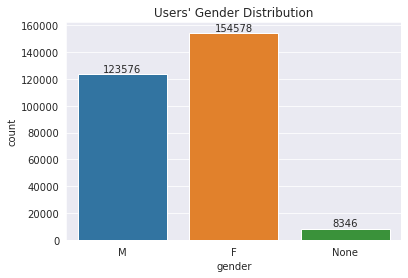

In [65]:
# replace the the missing values with string "None"
df_frame.gender.fillna("None", inplace=True)

# plot the gender distribution
ax = sns.countplot(x='gender', data=df_frame)
ax.bar_label(ax.containers[0]);
plt.title("Users' Gender Distribution");

### <font color='blue'>level Column</font>

In [15]:
# the level of the user for a given log session
(df
    .select("level")
    .where(col("level").isNotNull())
    .distinct()
    .show())

+-----+
|level|
+-----+
| free|
| paid|
+-----+



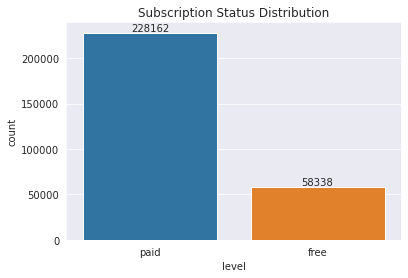

In [66]:
# replace the the missing values with string "None"
df_frame.level.fillna("None", inplace=True)

# plot the gender distribution
ax = sns.countplot(x="level", data=df_frame)
ax.bar_label(ax.containers[0]);
plt.title("Subscription Status Distribution");

### <font color='blue'>method Column</font>

The Hypertext Transfer Protocol (HTTP) is designed to enable communications between clients and servers. HTTP works as a request-response protocol between a client and server. _GET_ is used to request data from a specified resource. _PUT_ is used to send data to a server to create/update a resource; see [HTTP Request Forms](https://www.w3schools.com/tags/ref_httpmethods.asp).

In [16]:
# the HTTP request method initiated by the user
(df
    .select("method")
    .where(col("method").isNotNull())
    .distinct()
    .show())

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



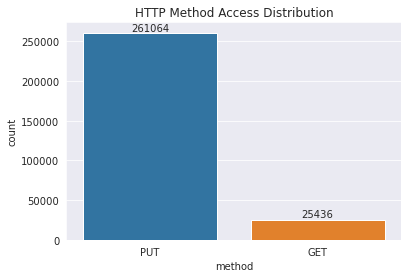

In [67]:
# replace the the missing values with string "None"
df_frame.method.fillna("None", inplace=True)

# plot the gender distribution
ax = sns.countplot(x="method", data=df_frame)
ax.bar_label(ax.containers[0]);
plt.title("HTTP Method Access Distribution");

### <font color='blue'>status Column</font>

The entries represent HTTP status codes. Three such codes cn be found in this dataset:

- 200 - OK, the request has succeeded  
- 307 - temporary redirect
- 404 - not found

For a full list see: [HTTP Status Codes Definitions](https://www.w3.org/Protocols/rfc2616/rfc2616-sec10.html)

In [20]:
# the status column gives HTTP status code
(df
    .select("status")
    .where(col("status").isNotNull())
    .distinct()
    .show())

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



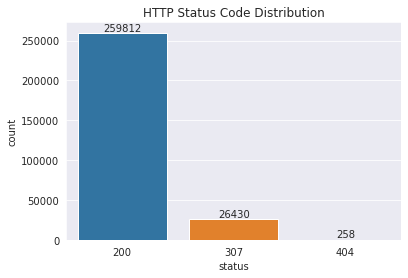

In [68]:
# replace the the missing values with string "None"
df_frame.status.fillna("None", inplace=True)

# plot the gender distribution
ax = sns.countplot(x="status", data=df_frame)
ax.bar_label(ax.containers[0]);
plt.title("HTTP Status Code Distribution");

In [69]:
# take a look at the entries that have status 404
df_error = df_frame[df_frame["status"] == 404]
df_error.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
939,None,Logged In,Kael,M,48,Baker,NaN,paid,"Kingsport-Bristol-Bristol, TN-VA",GET,Error,1.533102e+12,249,None,404,1538393848000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
1654,None,Logged In,Lucero,F,10,Reed,NaN,free,"Louisville/Jefferson County, KY-IN",GET,Error,1.536642e+12,139,None,404,1538407927000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",140
2710,None,Logged In,Sebastian,M,38,Wang,NaN,free,"Jackson, MS",GET,Error,1.538050e+12,52,None,404,1538425401000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",53
4488,None,Logged In,Micah,M,38,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Error,1.538332e+12,262,None,404,1538489751000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
5425,None,Logged In,Payton,F,19,Campbell,NaN,free,"Los Angeles-Long Beach-Anaheim, CA",GET,Error,1.529028e+12,354,None,404,1538515176000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",39


In [70]:
# a look at the other columns when status = 404
df_error.nunique()

artist             0
auth               3
firstName        109
gender             3
itemInSession    157
lastName          92
length             0
level              2
location          75
method             1
page               1
registration     117
sessionId        230
song               0
status             1
ts               258
userAgent         44
userId           118
dtype: int64

In [71]:
# determine how many records have status 404
print("There are {} records where the HTTP status is 404, page not found.".format(df_error.shape[0]))

There are 258 records where the HTTP status is 404, page not found.


In [79]:
# determine how many of the status 404 records correspond to paid customers
error_paid = df_error[df_error["level"] == "paid"]
error_paid.nunique()

artist             0
auth               2
firstName         91
gender             3
itemInSession    135
lastName          79
length             0
level              1
location          67
method             1
page               1
registration      95
sessionId        178
song               0
status             1
ts               201
userAgent         39
userId            96
dtype: int64

In [80]:
# take a look at the paid customers with status 404
error_paid.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
939,None,Logged In,Kael,M,48,Baker,NaN,paid,"Kingsport-Bristol-Bristol, TN-VA",GET,Error,1.533102e+12,249,None,404,1538393848000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131
6769,None,Logged In,Alexander,M,189,Garcia,NaN,paid,"Indianapolis-Carmel-Anderson, IN",GET,Error,1.536817e+12,104,None,404,1538547956000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105
7516,None,Logged In,Panav,M,76,Myers,NaN,paid,"Morgantown, WV",GET,Error,1.538239e+12,287,None,404,1538572413000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15
11487,None,Logged In,Nicole,F,100,Beck,NaN,paid,"Vineland-Bridgeton, NJ",GET,Error,1.532224e+12,420,None,404,1538673969000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124
12992,None,Logged In,Nicole,F,346,Beck,NaN,paid,"Vineland-Bridgeton, NJ",GET,Error,1.532224e+12,420,None,404,1538724012000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124


In [85]:
# take a closer look at the sessions of a paid customer
error_paid[error_paid["userId"]=="124"]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
11487,None,Logged In,Nicole,F,100,Beck,NaN,paid,"Vineland-Bridgeton, NJ",GET,Error,1.532224e+12,420,None,404,1538673969000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124
12992,None,Logged In,Nicole,F,346,Beck,NaN,paid,"Vineland-Bridgeton, NJ",GET,Error,1.532224e+12,420,None,404,1538724012000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124
23432,None,Logged In,Nicole,F,62,Beck,NaN,paid,"Vineland-Bridgeton, NJ",GET,Error,1.532224e+12,517,None,404,1539027101000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124
53422,None,Logged In,Nicole,F,305,Beck,NaN,paid,"Vineland-Bridgeton, NJ",GET,Error,1.532224e+12,708,None,404,1539740355000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124
53760,None,Logged In,Nicole,F,341,Beck,NaN,paid,"Vineland-Bridgeton, NJ",GET,Error,1.532224e+12,708,None,404,1539746713000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124
209521,None,Logged In,Nicole,F,99,Beck,NaN,paid,"Vineland-Bridgeton, NJ",GET,Error,1.532224e+12,2372,None,404,1543515887000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",124


<div class="alert alert-block alert-info">
    
There are 258 rows in the data that have status 404, page no found. 
- All these records have _GET_ as HTTP method.
- Some paid customers, such as the _userId_=124 have multiple sessions where _status_ = 404.

Although there are only a handful of such errors in the sample dataset, we have to investigate them in the full dataset also. Having troubles in logging in is a possible reason for a paid customer to cancel the subscription. 
    
</div>

In [17]:
# the entries in auth column indicate the activity type of the user
(df 
    .select("auth") 
    .where(col("auth").isNotNull()) 
    .distinct() 
    .show())

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



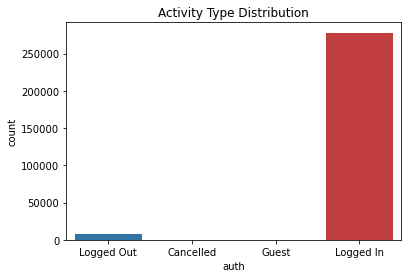

In [18]:
# plot the activity type distribution

# create the count dataframe
auth_df = df.groupby("auth").count().toPandas()

# create the figure and title
plt.figure()
sns.barplot(x="auth", y="count", data=auth_df)

plt.title("Activity Type Distribution")

plt.show()

In [19]:
# create a dataframe with unique distinct types of actions - pages
pages_collect = df.select("page") \
        .where(col("page").isNotNull()) \
        .distinct() \
        .collect()

# collect all the pages in a list
pages = []
print('\nThe following pages are available for the users:\n')
for row in pages_collect:
    # create a list of pages
    pages.append(str(row['page']))
    # print the page name
    print(str(row['page']))


The following pages are available for the users:

Cancel
Submit Downgrade
Thumbs Down
Home
Downgrade
Roll Advert
Logout
Save Settings
Cancellation Confirmation
About
Submit Registration
Settings
Login
Register
Add to Playlist
Add Friend
NextSong
Thumbs Up
Help
Upgrade
Error
Submit Upgrade


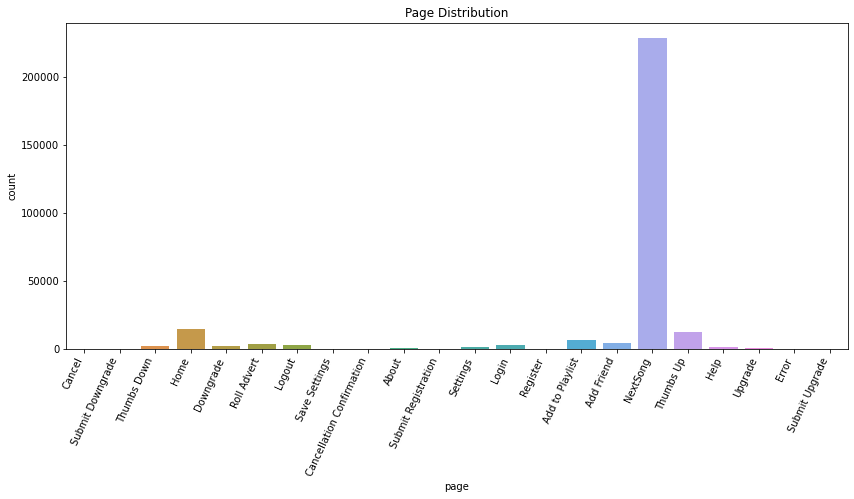

In [20]:
# plot the page usage distribution

# create the count dataframe
page_df = df.groupby("page").count().toPandas()

# create the figure and title
plt.figure(figsize=(14, 6))
sns.barplot(x="page", y="count", data=page_df)

plt.title("Page Distribution")
plt.xticks(rotation=65, horizontalalignment='right')

plt.show()

In [21]:
# most of the actions are on NextSong, then Home and ThumbsUp
page_df.sort_values(by="count", ascending=False)

,page,count
16,NextSong,228108
3,Home,14457
17,Thumbs Up,12551
14,Add to Playlist,6526
15,Add Friend,4277
5,Roll Advert,3933
12,Login,3241
6,Logout,3226
2,Thumbs Down,2546
4,Downgrade,2055


### <font color='blue'>Analyze Text Features</font>

In [22]:
# the location associated to the user, format City, State
(df
    .select("location")
    .where(col("location").isNotNull())
    .distinct()
    .show(10, truncate=False))

+--------------------------------------+
|location                              |
+--------------------------------------+
|Gainesville, FL                       |
|Atlantic City-Hammonton, NJ           |
|Deltona-Daytona Beach-Ormond Beach, FL|
|San Diego-Carlsbad, CA                |
|Cleveland-Elyria, OH                  |
|Kingsport-Bristol-Bristol, TN-VA      |
|New Haven-Milford, CT                 |
|Birmingham-Hoover, AL                 |
|Corpus Christi, TX                    |
|Dubuque, IA                           |
+--------------------------------------+
only showing top 10 rows



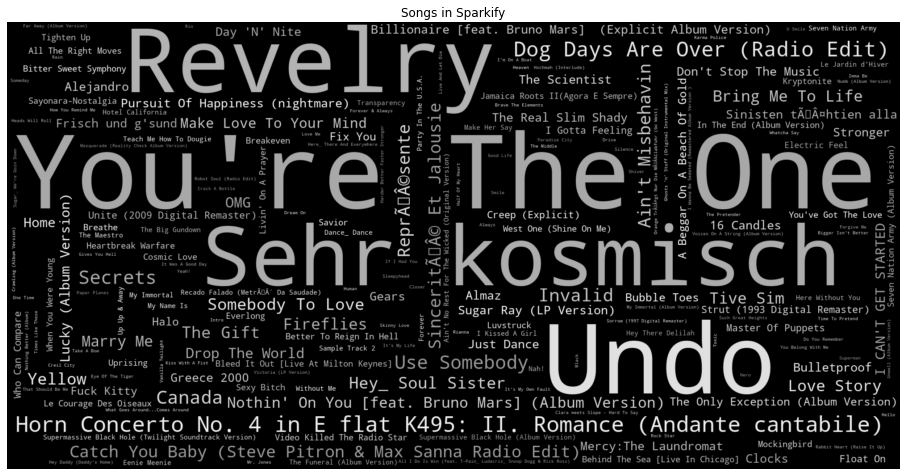

In [52]:
# function from https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# create a simple wordcloud with the song titles
df_frame = df.toPandas()
songs_df = df_frame['song'].value_counts().to_dict()

# create the figure and title
plt.figure(figsize=(16, 10))

# generate the wordcloud from frequencies
wc = WordCloud(width = 2000, 
               height=1000, 
               margin=10, 
               random_state=1).generate_from_frequencies(songs_df)

# display the fitted and recolored wordcloud
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")

# turn axis off to get rid of axis numbers
plt.axis('off')

# create title
plt.title("Songs in Sparkify")

# save to file
wc.to_file("sparkify_songs.png")

plt.show()


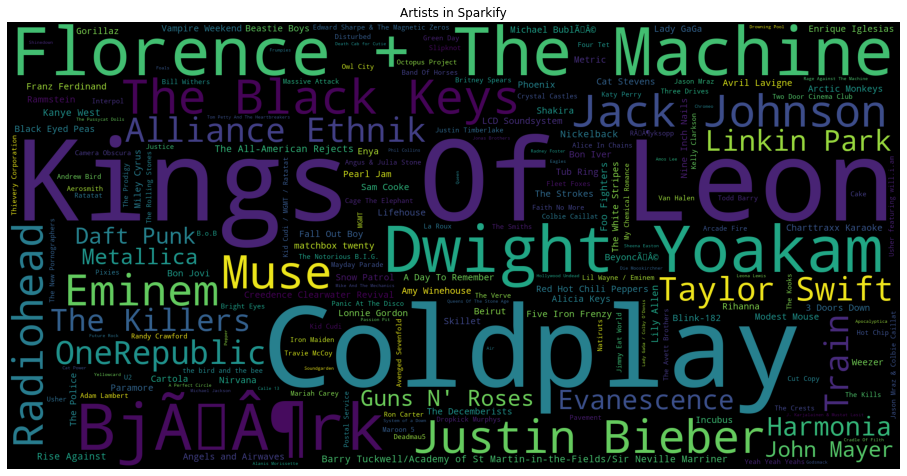

In [53]:
# create a simple wordcloud with artist names
df_frame = df.toPandas()
artists_df = df_frame['artist'].value_counts().to_dict()

# create the figure and title
plt.figure(figsize=(16, 10))

# generate the wordcloud from frequencies
wc = WordCloud(width = 2000, 
               height=1000, 
               margin=10, 
               random_state=1).generate_from_frequencies(artists_df)

# display the fitted wordcloud
plt.imshow(wc)

# turn axis off to get rid of axis numbers
plt.axis('off')

# create title
plt.title("Artists in Sparkify")

# save to file
wc.to_file("sparkify_artists.png")

plt.show()

### <font color='blue'>Descriptions of the Features</font>

|Information| Column | DType | Brief Description |
| --------- | :----- | :---- | :---------------- |
| user-info| userId | string | unique identifier of the user|
| user-info | firstName | string | user's first name |
| user-info | lastName | string | user's last name |
| user-info | gender | string | user's gender, values: _F_, _M_ |
| user-info | location | string | user's location |
| user-info | userAgent | string | information on the browser used by the user |
| user-info | level | string | subscription level, values: _free_, _paid_ |
| user-info | registration | bigint | user's registration timestamp |
|           |              |                                        |
| song-info | artist | string | artist's name the song is by |
| song-info | song | string | song's name |
| song-info | length | double | song's length in seconds |
|           |        |        |                          |
| log-info | auth | string | authentication: _Logged In_, _Logged Out_, _Cancelled_, _Guest_|
| log-info | itemInSession | bigint | number of logs in the session |
| log-info | method | string | HTTP request method, values: _GET_, _PUT_ |
| log-info | page | string | type of action, 22 values: _Home_, _About_, _NextSong_, etc. |
| log-info | sessionId | bigint | session id|
| log-info | status | bigint | HTTP status code: values _200_, _404_, _307_ |
| log-info | ts | bigint | timestamp of the log event |



### <font color='blue'>Rows With Zero itemInSession</font>

In [62]:
# print descriptive statistics for itemInSession column
df.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201141113|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [63]:
# create a dataframe for those data points with itemInSession=0
itemInSession_zero = df[df['itemInSession'] == 0]
# find how many entries have itemInSession = 0
itemInSession_zero.count()

3278

In [64]:
# take a look at some of the data with 0 logs in session
itemInSession_zero.take(2)

[Row(artist='Tokyo Police Club', auth='Logged In', firstName='Ashlynn', gender='F', itemInSession=0, lastName='Williams', length=166.1122, level='free', location='Tallahassee, FL', method='PUT', page='NextSong', registration=1537365219000, sessionId=217, song='Citizens Of Tomorrow', status=200, ts=1538353668000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', userId='74'),
 Row(artist='Modjo', auth='Logged In', firstName='Alexi', gender='F', itemInSession=0, lastName='Warren', length=250.93179, level='paid', location='Spokane-Spokane Valley, WA', method='PUT', page='NextSong', registration=1532482662000, sessionId=53, song='What I Mean', status=200, ts=1538353930000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0', userId='54')]

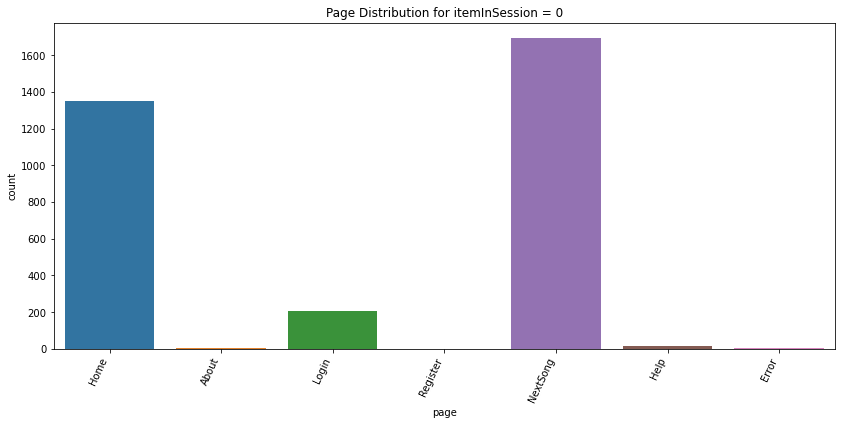

In [65]:
# plot the page usage distribution for zero itemInSession

# create the count dataframe
itemInSession_page = itemInSession_zero.groupby("page").count().toPandas()

# create the figure and title
plt.figure(figsize=(14, 6))
sns.barplot(x="page", y="count", data=itemInSession_page)

plt.title("Page Distribution for itemInSession = 0")
plt.xticks(rotation=65, horizontalalignment='right')

plt.show()

### <font color='blue'>Rows With Empyty User Id</font>

In [55]:
# take a look at the empy string userId
df[df['userId'] == ""].show(4)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [56]:
# filter for users with blank user id
blank_users = df.filter(df.userId == "").toPandas()

# take a look at the data
blank_users.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,None,200,1538356678000,None,


In [57]:
# count the unique entries in blank_users
blank_users.nunique()

artist              0
auth                2
firstName           0
gender              0
itemInSession     565
lastName            0
length              0
level               2
location            0
method              2
page                7
registration        0
sessionId        1629
song                0
status              3
ts               8305
userAgent           0
userId              1
dtype: int64

In [58]:
# which pages do the users with no id visit
blank_users.groupby("page").count()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,registration,sessionId,song,status,ts,userAgent,userId
page,,,,,,,,,,,,,,,,,
About,0,429,0,0,429,0,0,429,0,429,0,429,0,429,429,0,429
Error,0,6,0,0,6,0,0,6,0,6,0,6,0,6,6,0,6
Help,0,272,0,0,272,0,0,272,0,272,0,272,0,272,272,0,272
Home,0,4375,0,0,4375,0,0,4375,0,4375,0,4375,0,4375,4375,0,4375
Login,0,3241,0,0,3241,0,0,3241,0,3241,0,3241,0,3241,3241,0,3241
Register,0,18,0,0,18,0,0,18,0,18,0,18,0,18,18,0,18
Submit Registration,0,5,0,0,5,0,0,5,0,5,0,5,0,5,5,0,5


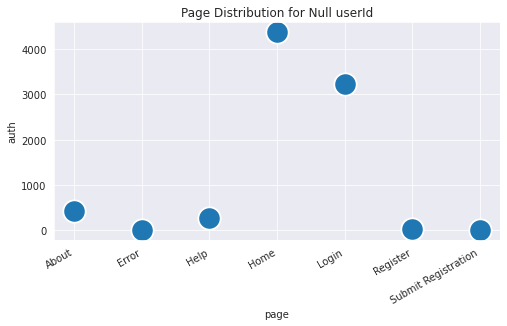

In [72]:
# plot the page usage distribution for null userId

# create the count dataframe
blank_users_page = blank_users.groupby(["page"]).count()

# create the figure and title
plt.figure(figsize=(8, 4))
sns.scatterplot(x="page", y="auth", data=blank_users_page, s=500)

plt.title("Page Distribution for Null userId")
plt.xticks(rotation=30, horizontalalignment='right')

plt.show()

In [78]:
# print descriptive statistics for songs length
df.describe("length").show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783478|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



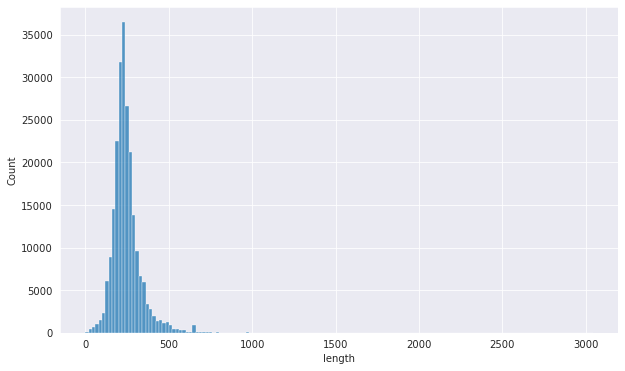

In [83]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_frame, x="length", binwidth=20);

In [88]:
df[df['length']> 1000].count()

282